# **EAI6010 - Module1 Assignment - MNIST**
## Name - Jinsheng Wei

First, we have to import some of the libraries we will use in this
assignment.

We use the DataLoader and Dataset API to read the MNIST data.
And we also need untar_data, URLs package to download MNIST data online.

Torch.nn module to build up the classification model.

Mataplotlib.pyplot for graphing.

Numpy for manipulating the data.

In [14]:
# Import required libraries
import torch
from torch import nn, tensor
from torch.utils.data import DataLoader, TensorDataset
from fastai.vision.all import untar_data, URLs
from PIL import Image
import matplotlib.pyplot as plt
import time
import numpy as np

Loading the data by using the fastai.vision.all package.


Transfer the data type from PIL to np.array to tensor.


And also make the value of the tensor in range [0,1].


By this step we have three_tensor which contains all the pictures represent number 3 in a tensor format and seven_tensor which contains all the pictures represent number 7 in a tensor format.

In [16]:
# Load and prepare data
path = untar_data(URLs.MNIST_SAMPLE)
three_tensors = torch.stack([tensor(np.array(Image.open(o)))  # Convert PIL image to numpy array
    for o in (path/'train'/'3').ls()]).float()/255
seven_tensors = torch.stack([tensor(np.array(Image.open(o))) # Convert PIL image to numpy array
    for o in (path/'train'/'7').ls()]).float()/255

By this block below.

We plot 3 graphs about one sample which is the first picture in our three_tensors variable. The left one is the origin image.(black and white color, and the numeric pixel value is between [0,255])

The one in the middle is the heatmap.

The right one is the zoomed version of the heatmap.It captures the local charcter.

Visualizing first digit 7:


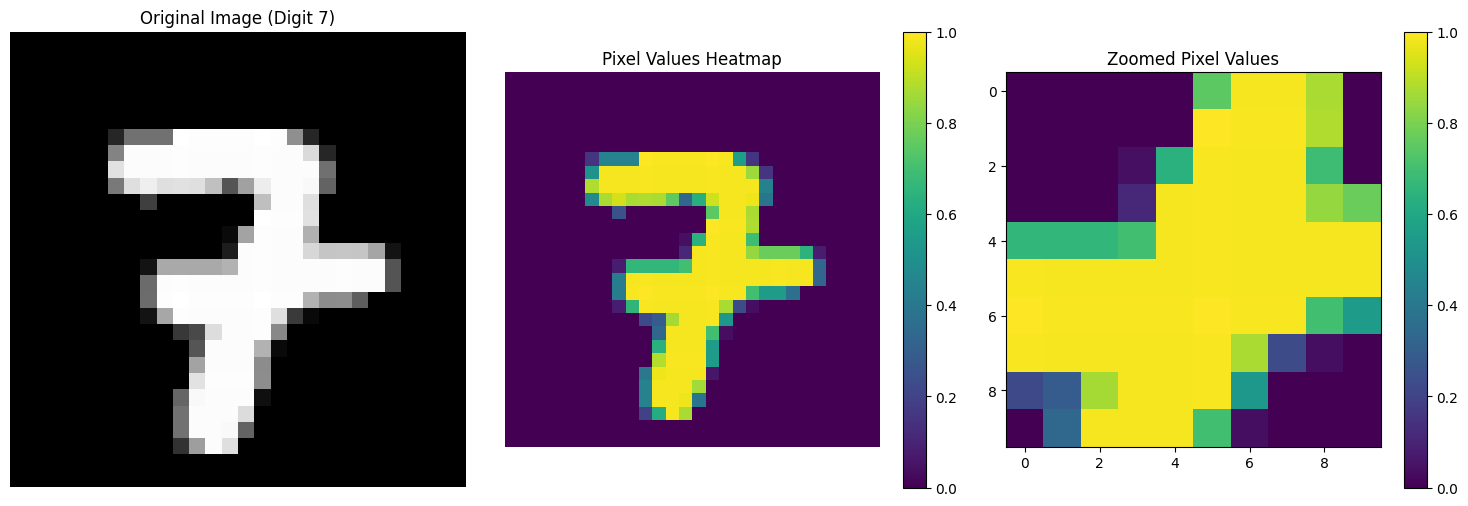


Numeric pixel values (10x10 section):
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7490, 0.9882, 0.9882, 0.8745,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.9922, 0.9922, 0.8824,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0392, 0.6392, 0.9922, 0.9882, 0.9882, 0.6902,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.1137, 0.9882, 0.9922, 0.9882, 0.9882, 0.8431,
         0.7725],
        [0.6627, 0.6627, 0.6627, 0.6980, 0.9882, 0.9922, 0.9882, 0.9882, 0.9882,
         0.9882],
        [0.9922, 0.9882, 0.9882, 0.9882, 0.9882, 0.9922, 0.9882, 0.9882, 0.9882,
         0.9882],
        [1.0000, 0.9922, 0.9922, 0.9922, 0.9922, 1.0000, 0.9922, 0.9922, 0.6980,
         0.5490],
        [0.9922, 0.9882, 0.9882, 0.9882, 0.9882, 0.9922, 0.8745, 0.2275, 0.0353,
         0.0000],
        [0.2196, 0.2902, 0.8667, 0.9882, 0.9882, 0.9922, 0.5333, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.3333, 0.9882, 0.9882, 0.9882, 0.6980, 0.0353, 0.000

In [36]:
def visualize_digit_representation(digit_type='three', index=0):
    """
    Visualize digit representation with customizable image selection
    digit_type: 'three' or 'seven' to choose digit type
    index: index of the image to visualize
    """
    # Select image based on parameters
    if digit_type.lower() == 'three':
        sample_img = three_tensors[index]
        digit = '3'
    else:
        sample_img = seven_tensors[index]
        digit = '7'

    # Create a figure with 3 subplots
    plt.figure(figsize=(15,5))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(sample_img, cmap='gray')
    plt.title(f'Original Image (Digit {digit})')
    plt.axis('off')

    # Pixel values heatmap
    plt.subplot(1,3,2)
    plt.imshow(sample_img, cmap='viridis')
    plt.title('Pixel Values Heatmap')
    plt.colorbar()
    plt.axis('off')

    # Zoomed section with pixel values
    plt.subplot(1,3,3)
    zoomed = sample_img[10:20, 10:20]
    plt.imshow(zoomed, cmap='viridis')
    plt.title('Zoomed Pixel Values')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    # Print actual numeric values
    print("\nNumeric pixel values (10x10 section):")
    print(zoomed)

# Visualize first '3'
print("Visualizing first digit 7:")
visualize_digit_representation('seven', 8)

Split the dataset into two parts.

The first part is training set.

The second part is validation set.

The cut-off rating here i set is 0.8.

We can easily complete this part by using the view and unsqueeze method in pytorch which is really helpful.

In [21]:
# Create training and validation sets
train_size = int(0.8 * len(three_tensors))
X_train = torch.cat([three_tensors[:train_size], seven_tensors[:train_size]]).view(-1, 28*28)
y_train = tensor([1]*train_size + [0]*train_size).unsqueeze(1)

X_valid = torch.cat([three_tensors[train_size:], seven_tensors[train_size:]]).view(-1, 28*28)
y_valid = tensor([1]*(len(three_tensors)-train_size) + [0]*(len(seven_tensors)-train_size)).unsqueeze(1)

After we split the data we need to using the dataloader function to send our data into the model in a small batch each time.

Why mini-batch? A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU.

In [22]:
# Create DataLoaders
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64)

Here we create our model.

In this assignment, I decide to use the neural network with 6 layers (3 of them are linear and the rest are non-linear).

By using the nn.sequential module is easy to build up a model and perform it in a sequential way. The active function here I picked is Relu which is commonly use in machine learning.

By combining these two tpyes of functions we can make our model more complex and more powerful.

Since we would like to solve a binary-classification problem, then the loss function here I chose is the BCE loss.

And we would like to update our gradient in SGD.

In [23]:
# Create model
model = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

We design this function is for evaluate our model's matrics.
Some of the readers did not know much about the machine learning, with the accuracy index, they can easily understand the performance.

In [24]:
# Function to calculate accuracy
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct/total

In this block we train our model in 20 epochs, and evaluate in valid set to test its performance.

We found that in epoch 10, the vaild loss is smallest.
Maybe we can stop at the epoch 10, otherwise we may face the overfitting problem.

In [27]:
# Print header
print("\nStarting training:")
print(f"{'epoch':>5} {'train_loss':>10} {'valid_loss':>10} {'batch_accuracy':>14} {'time':>8}")
print("-" * 50)

# Training loop with metrics
start_time = time.time()
for epoch in range(20):
    epoch_start = time.time()
    model.train()
    total_loss = 0
    batch_count = 0

    # Training phase
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1

    # Calculate metrics
    train_loss = total_loss / batch_count

    # Validation phase
    model.eval()
    valid_loss = 0
    valid_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_dl:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.float())
            valid_loss += loss.item()
            valid_batches += 1
    valid_loss /= valid_batches

    # Calculate accuracy
    accuracy = calculate_accuracy(model, valid_dl)

    # Calculate epoch time
    epoch_time = time.time() - epoch_start

    # Print metrics
    print(f"{epoch:5d} {train_loss:10.6f} {valid_loss:10.6f} {accuracy:14.6f} {epoch_time:8.2f}")


Starting training:
epoch train_loss valid_loss batch_accuracy     time
--------------------------------------------------
    0   0.014467   0.021268       0.993818     0.47
    1   0.009998   0.019959       0.993045     0.42
    2   0.007403   0.019316       0.994204     0.43
    3   0.005749   0.020467       0.994590     0.41
    4   0.004808   0.019010       0.994204     0.42
    5   0.003783   0.019286       0.994590     0.43
    6   0.003125   0.020308       0.994977     0.41
    7   0.002562   0.022329       0.993431     0.43
    8   0.002292   0.021157       0.994204     0.49
    9   0.001922   0.020160       0.994204     0.61
   10   0.001669   0.019376       0.993818     0.60
   11   0.001247   0.020391       0.994590     0.64
   12   0.000797   0.020514       0.994590     0.65
   13   0.000646   0.019910       0.993818     0.58
   14   0.000540   0.020791       0.994204     0.41
   15   0.000486   0.022240       0.994590     0.42
   16   0.000438   0.021059       0.994590   

In this step, we built a function that randomly selects six images from our dataset, makes predictions on them, and visualizes the prediction results to see how well our model performs. In the predictions, a value closer to 0 indicates that our model believes the image is the digit 7, while a value closer to 1 indicates that the model believes the image is the digit 3.


Visualizing random predictions:


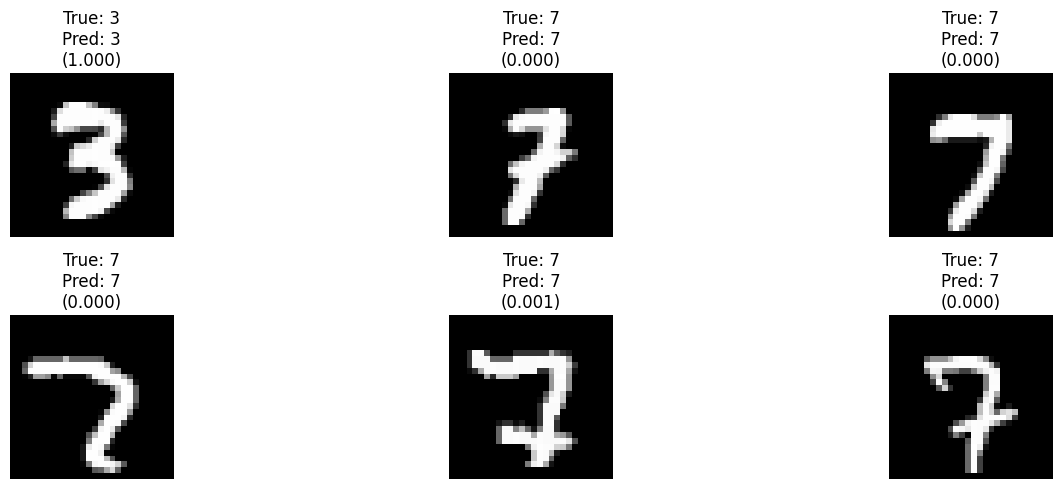

In [30]:
def visualize_random_predictions(num_samples=6):
    model.eval()
    plt.figure(figsize=(15, 5))

    # Combine and shuffle test images
    all_test_images = torch.cat([
        three_tensors[train_size:],
        seven_tensors[train_size:]
    ])
    all_test_labels = ['3'] * (len(three_tensors)-train_size) + \
                      ['7'] * (len(seven_tensors)-train_size)

    # Randomly select indices
    import random
    indices = random.sample(range(len(all_test_images)), num_samples)

    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i+1)
        test_img = all_test_images[idx].unsqueeze(0).view(-1, 28*28)
        true_label = all_test_labels[idx]

        with torch.no_grad():
            pred = torch.sigmoid(model(test_img))

        plt.imshow(all_test_images[idx], cmap='gray')
        plt.title(f'True: {true_label}\nPred: {"3" if pred > 0.5 else "7"}\n({pred.item():.3f})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing random predictions:")
visualize_random_predictions(6)  # Show 6 random samples

In summary, this week through fastai's MNIST dataset prediction case, I learned how to create a binary classification model for digit recognition and achieved high classification accuracy through modeling. I spent a lot of time learning every detail of the process, and I truly gained a lot from it. This experience has given me more confidence for future challenges.